## This Notebook trains a Neural Network for Galaxy-Matter-Powerspektra Predictions

In [1]:
import g3lhalo
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np
import random
from pyDOE import lhs
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os
import corner
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_addons as tfa
import optuna
from tensorflow.keras.layers import LeakyReLU, ELU

# Für spezielle Aktivierungen wie Swish, GELU
try:
    from tensorflow.keras.activations import swish, gelu
except ImportError:
    # Alternative falls alte TensorFlow-Version
    def swish(x): return x * tf.nn.sigmoid(x)
    def gelu(x): return 0.5 * x * (1.0 + tf.tanh(tf.sqrt(2.0 / tf.constant(np.pi)) * (x + 0.044715 * tf.pow(x, 3))))

# Für AdamW und RAdam Optimizer:
try:
    from tensorflow_addons.optimizers import AdamW, RectifiedAdam
except ImportError:
    # Falls nicht installiert:
    # pip install tensorflow-addons
    print("Installiere tensorflow-addons mit: pip install tensorflow-addons")

2025-07-08 14:08:52.933104: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 14:08:52.936043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 14:08:52.984166: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 14:08:52.985251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 14:09:00.146794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [ ]:
#%pip install tensorflow
#%pip install pyDOE
#%pip install pandas
#%pip install seaborn
#%pip install tensorflow-addons
#%pip install filelock
#%pip install pyccl

In [3]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
using cpu device 



In [ ]:
# setting the seed for reproducibility
np.random.seed(9721)
tf.random.set_seed(9721)

## Read in generated Targets

In [ ]:
# Create directory to save the generated data
data_dir = "../Data/"
os.makedirs(data_dir, exist_ok=True)

In [6]:
data_dir = "../Data/"
data_fn = f"{data_dir}GeneratedData_1000000_2025-06-11_05-16-31.json"

# 2. Relevante Keys für Galaxy-Matter

target_keys = ['Pk_ll_1h', 'Pk_ll_2h', 'Pk_ll']
lin_keys = ['Pk_lin']


# 3. Daten einlesen und filtern

clean_samples = []
kept_indices = []
with open(data_fn, "r") as json_file:
    data_samples = json.load(json_file)
    for i, sample in enumerate(data_samples):
        if all(np.all(np.array(sample[key]) >= 0) for key in target_keys):
            clean_samples.append(sample)
            kept_indices.append(i)

print(f"Anzahl der verbleibenden (bereinigten) Samples: {len(clean_samples)}")


# Create numpy arrays for each of the Pk_* columns
targets_array = {
    key: np.array([sample[key] for sample in clean_samples])
    for key in target_keys
}


# Logarithmic transformation of the data
def log_transform(targets_array):
    return {key: np.log(data) for key, data in targets_array.items()}

#epsilon = 1e-8
#for key in targets_array:
    #targets_array[key] = np.where(targets_array[key] <= 0, epsilon, targets_array[key])

# Calculate logarithms of the data
log_transformed_data = log_transform(targets_array)

num_samples = len(clean_samples)
indices = np.arange(num_samples)
np.random.shuffle(indices)

training_indices = indices[:50000]
validation_indices = indices[50000:60000]
testing_indices = indices[60000:]

print(f"Training: {len(training_indices)}")
print(f"Validation: {len(validation_indices)}")
print(f"Test: {len(testing_indices)}")

# 8. Hilfsfunktion zum Splitten
def split_data(array_dict, split_indices):
    return np.array([data[split_indices] for data in array_dict.values()])

# 9. Targets und Modes für Splits
training_targets = {
    'modes': split_data(targets_array, training_indices),
    'targets': split_data(log_transformed_data, training_indices)
}

validation_targets = {
    'modes': split_data(targets_array, validation_indices),
    'targets': split_data(log_transformed_data, validation_indices)
}

testing_targets = {
    'modes': split_data(targets_array, testing_indices),
    'targets': split_data(log_transformed_data, testing_indices)
}

Anzahl der verbleibenden (bereinigten) Samples: 367826
Training: 50000
Validation: 10000
Test: 307826


In [ ]:
print('number of training targets:', len(training_targets['modes'][:][0]), '. Should be', len(training_indices))
print('number of validation targets:', len(validation_targets['modes'][:][0]), '. Should be', len(validation_indices))

print('number of test targets:', len(testing_targets['modes'][:][0]), '. Should be', len(testing_indices))

number of training targets: 50000 . Should be 50000
number of validation targets: 10000 . Should be 10000
number of test targets: 307826 . Should be 307826


In [ ]:
N_modes=len(training_targets['modes'])
print(f"Shape of training targets: {training_targets['targets'].shape}. Should be ({N_modes}, {len(training_indices)}, 50)")
print(f"Shape of testing targets: {testing_targets['targets'].shape}. Should be ({N_modes}, {len(testing_indices)}, 50)")
print(f"Shape of validation targets: {validation_targets['targets'].shape}. Should be ({N_modes}, {len(validation_indices)}, 50)")

Shape of training targets: (3, 50000, 50). Should be (3, 50000, 50)
Shape of testing targets: (3, 307826, 50). Should be (3, 307826, 50)
Shape of validation targets: (3, 10000, 50). Should be (3, 10000, 50)


## Read in related features

In [9]:
para_fn = f"{data_dir}Parameter_1000000_2025-06-11_05-16-31.json"

# Read in parameters
with open(para_fn, "r") as json_file:
    param_samples = json.load(json_file)

filtered_param_samples = [param_samples[i] for i in kept_indices]

# Extract feature arrays
feature_keys = ['Om_c', 'Om_b', 'h', 'sigma_8', 'n_s', 'alpha', 'sigma', 'Mth', 'Mprime', 'beta']
feature_array = {
    key: np.array([sample[key] for sample in filtered_param_samples])
    for key in feature_keys
}

# Split
training_features = {key: feature[training_indices] for key, feature in feature_array.items()}
validation_features = {key: feature[validation_indices] for key, feature in feature_array.items()}
testing_features = {key: feature[testing_indices] for key, feature in feature_array.items()}

# Convert to final numpy arrays
training_features = np.array(list(zip(*training_features.values())))
validation_features = np.array(list(zip(*validation_features.values())))
testing_features = np.array(list(zip(*testing_features.values())))

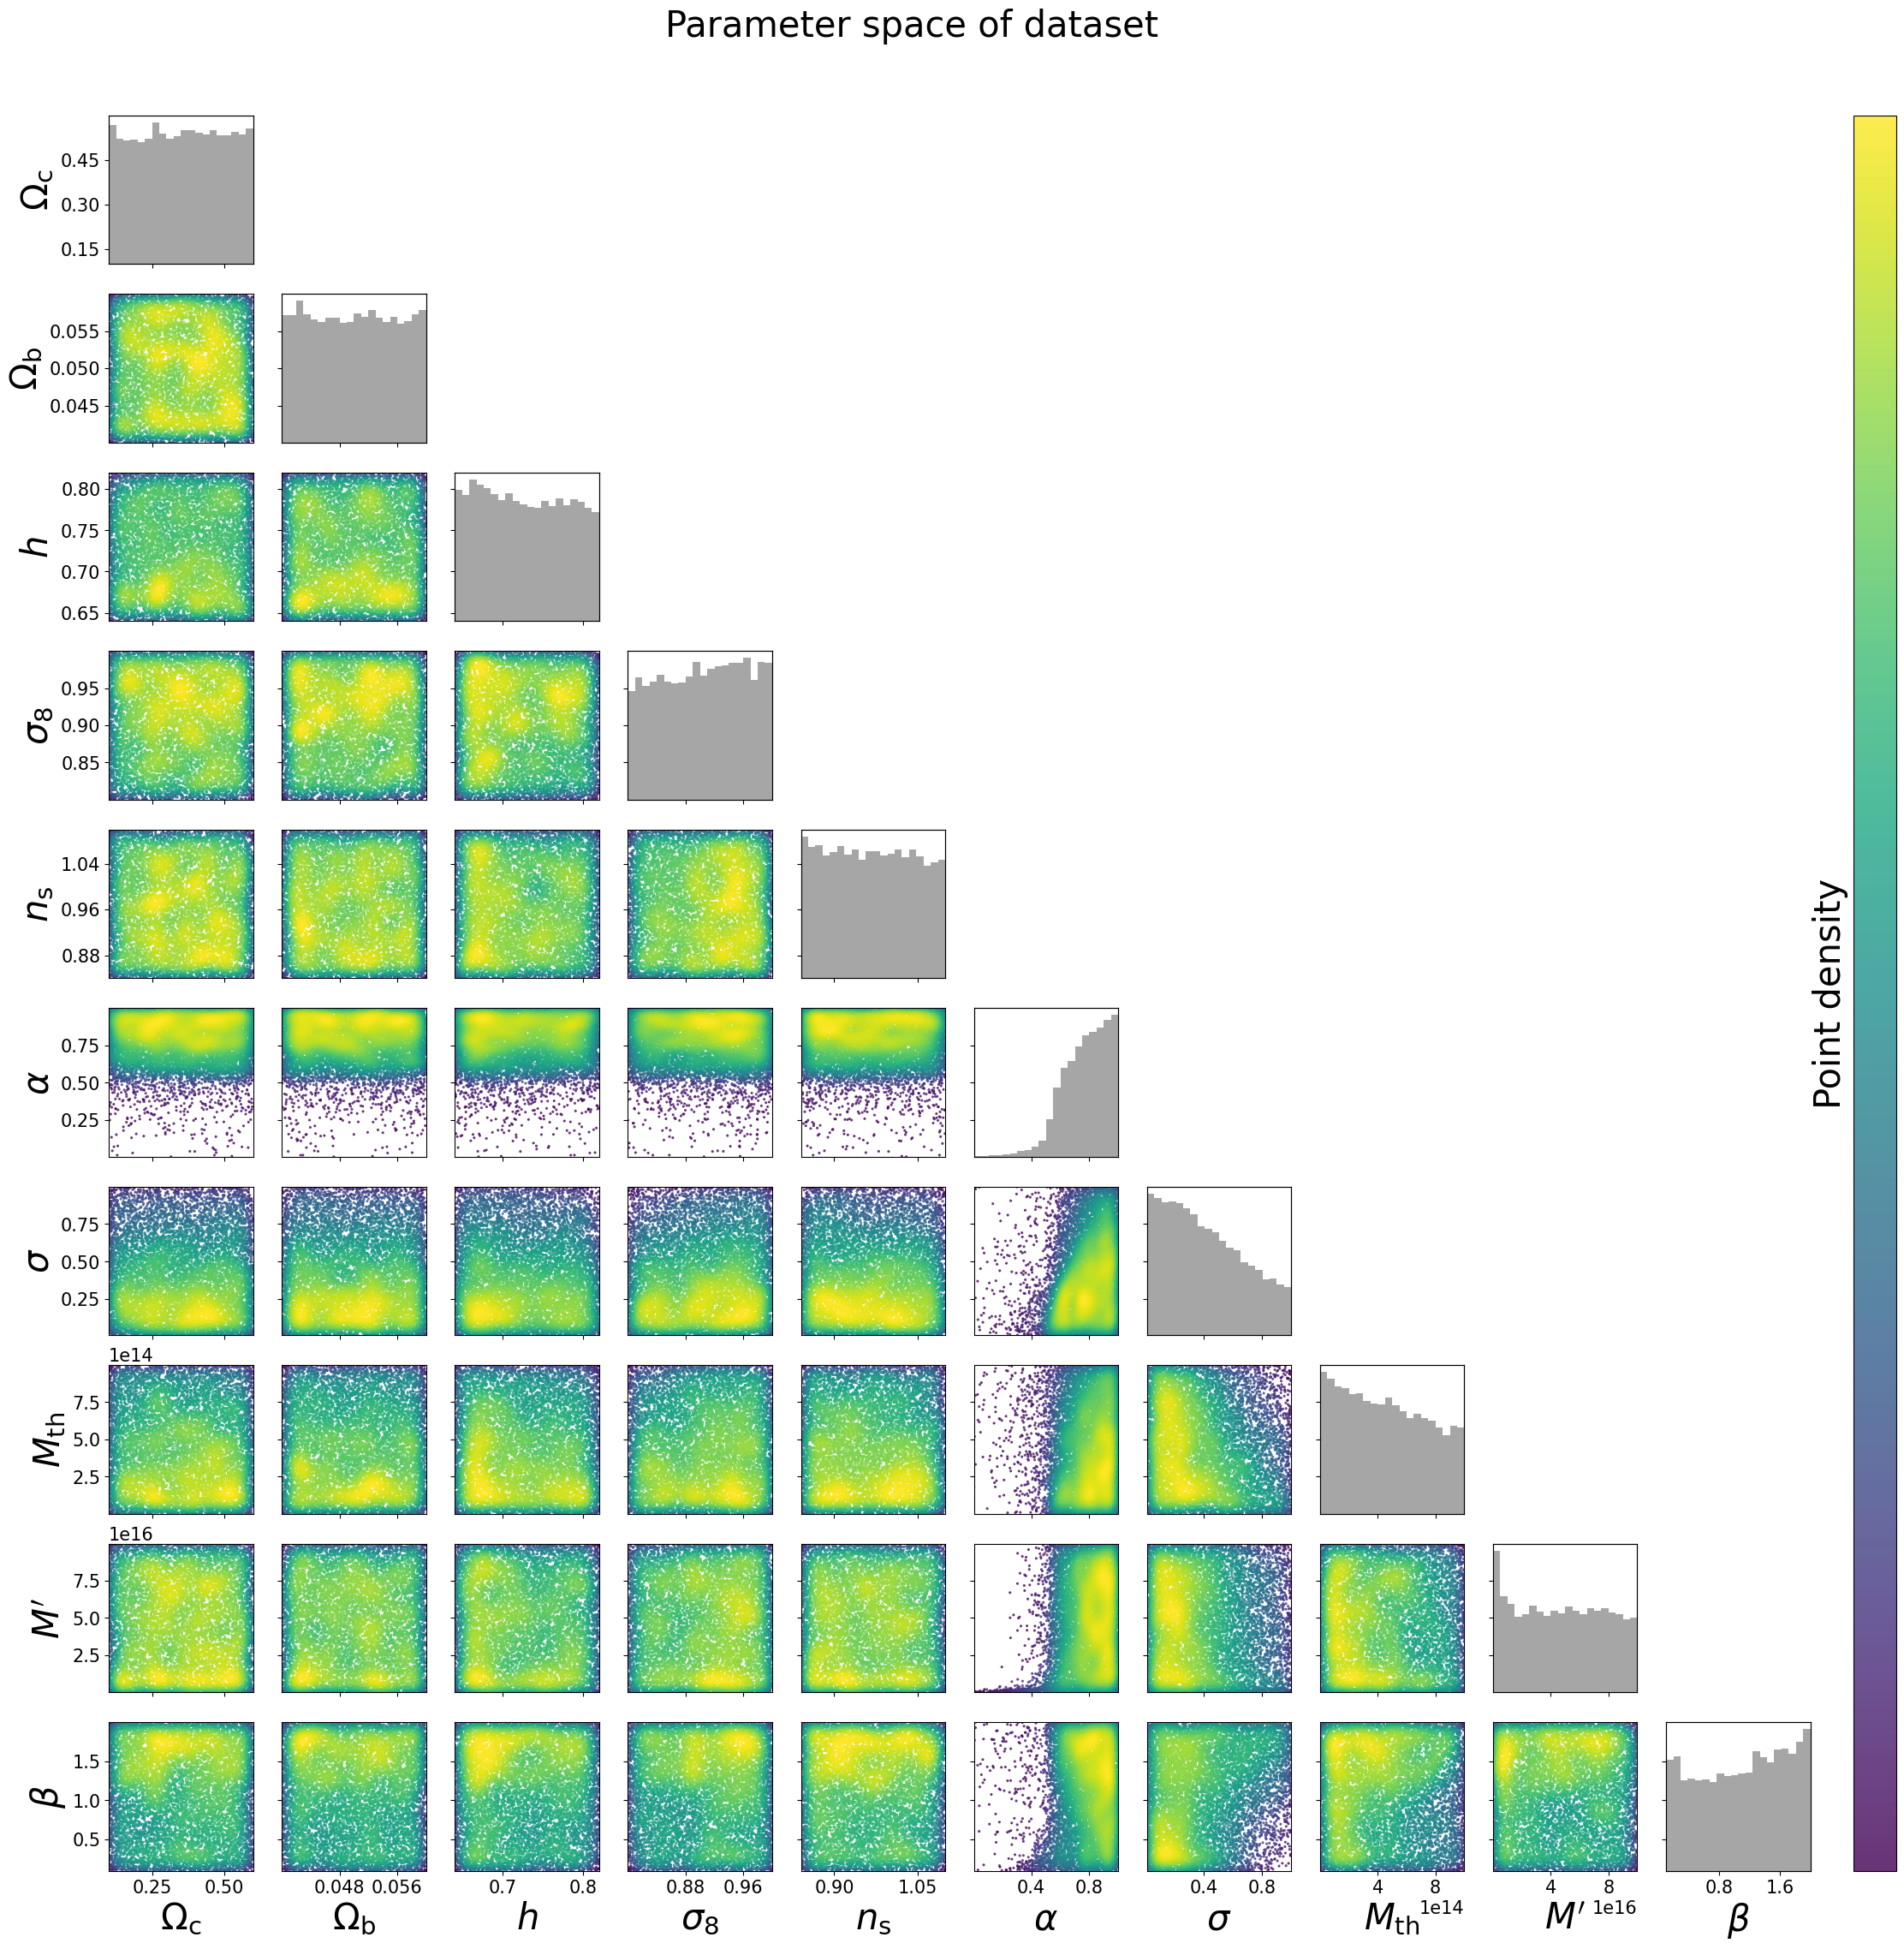

In [10]:
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# Beispiel: n_params = 10
data = validation_features
param_names = [
    r'$\Omega_\mathrm{c}$', r'$\Omega_\mathrm{b}$', r'$h$', r'$\sigma_8$', r'$n_\mathrm{s}$',
    r'$\alpha$', r'$\sigma$', r'$M_\mathrm{th}$', r'$M^\prime$', r'$\beta$'
]

n_params = data.shape[1]
fig, axes = plt.subplots(n_params, n_params, figsize=(2.5 * n_params, 2.5 * n_params))

scatter_for_colorbar = None  # Referenz für spätere Colorbar

for i in range(n_params):
    for j in range(n_params):
        ax = axes[i, j]
        x = data[:, j]
        y = data[:, i]

        if i < j:
            ax.axis("off")
            continue

        if i == j:
            ax_hist = ax.twinx()
            ax_hist.hist(x, bins=20, color='gray', alpha=0.7)
            ax_hist.set_yticks([])
            ax_hist.set_ylabel("")
        else:
            try:
                xy = np.vstack([x, y])
                z = gaussian_kde(xy)(xy)
                idx = z.argsort()
                scatter = ax.scatter(
                    x[idx], y[idx],
                    c=z[idx], cmap="viridis",
                    s=5, edgecolor="none", alpha=0.8
                )
                if scatter_for_colorbar is None:
                    scatter_for_colorbar = scatter
            except:
                ax.scatter(x, y, c='gray', s=5, alpha=0.5)

        # Dynamisch Ticks begrenzen
        ax.xaxis.set_major_locator(MaxNLocator(nbins='auto', prune='both'))
        ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune='both'))

        if i == n_params - 1:
            ax.set_xlabel(param_names[j], fontsize=30)
        else:
            ax.set_xticklabels([])

        if j == 0:
            ax.set_ylabel(param_names[i], fontsize=30)
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='both', which='both', labelsize=15)
        if ax.xaxis.get_offset_text() is not None:
            ax.xaxis.get_offset_text().set_fontsize(15)
        if ax.yaxis.get_offset_text() is not None:
            ax.yaxis.get_offset_text().set_fontsize(15)

        ax.set_xlim(np.min(x), np.max(x))
        ax.set_ylim(np.min(y), np.max(y))

fig.subplots_adjust(right=0.92, top=0.93)
fig.suptitle("Parameter space of dataset", fontsize=30)

# Colorbar ohne Skala, Label links von Colorbar
if scatter_for_colorbar:
    cbar_ax = fig.add_axes([0.94, 0.11, 0.02, 0.82])
    cbar = fig.colorbar(scatter_for_colorbar, cax=cbar_ax)
    cbar.set_label("Point density", fontsize=30)
    cbar.ax.yaxis.set_label_position('left')  # Label links neben Colorbar
    cbar.set_ticks([])  # Skala/Ticks entfernen

# Offset text Größen angleichen (zur Sicherheit)
for row in axes:
    for ax in row:
        if hasattr(ax, 'xaxis'):
            ax.xaxis.get_offset_text().set_fontsize(15)
        if hasattr(ax, 'yaxis'):
            ax.yaxis.get_offset_text().set_fontsize(15)

plt.savefig('../Plots/FinalExamples/ParameterspaceTest.png', dpi=300)
plt.show()


In [11]:
log_indices = [7, 8]  # Ersetze mit deinen echten Indizes

training_features[:, log_indices] = np.log10(training_features[:, log_indices])
validation_features[:, log_indices] = np.log10(validation_features[:, log_indices])
testing_features[:, log_indices] = np.log10(testing_features[:, log_indices])

print("input min/max:", training_features.min(), training_features.max())

input min/max: 0.0009879721492787466 16.99998162968257


In [ ]:
print('number of training features:', len(training_features), '. Should be', len(training_indices))
print('number of validation features:', len(validation_features), '. Should be', len(validation_indices))

print('number of test features:', len(testing_features), '. Should be', len(testing_indices))


number of training features: 50000 . Should be 50000
number of validation features: 10000 . Should be 10000
number of test features: 307826 . Should be 307826


## Cross check
Now, for a cross check we plot the mean of the training, testing and validation data sets. These should all look roughly the same, otherwise we have selected strange test and validation sets.

In [ ]:
mean_training_targets = []
std_training_targets = []

mean_testing_targets = []
std_testing_targets = []

mean_validation_targets = []
std_validation_targets = []

# Calculate mean and standard deviation for training targets
for i in range(len(training_targets['modes'])):  # for all 3-Halo terms
    halo_data = np.array(training_targets['targets'][i])
    
    mean = np.mean(halo_data, axis=0)  # mean over complete training sample for every k-value
    std = np.std(halo_data, axis=0)    # standard deviation over complete training sample for every k-value
    
    mean_training_targets.append(mean)
    std_training_targets.append(std)

# Calculate mean and standard deviation for testing targets
for i in range(len(testing_targets['modes'])):  # for all 3-Halo terms
    halo_data = np.array(testing_targets['targets'][i])

    mean = np.mean(halo_data, axis=0) # mean over complete testing sample for every k-value
    std = np.std(halo_data, axis=0)    # standard deviation over complete testing sample for every k-value

    mean_testing_targets.append(mean)
    std_testing_targets.append(std)

# Calculate mean and standard deviation for validation targets
for i in range(len(validation_targets['modes'])):  # for all 3-Halo terms
    halo_data = np.array(validation_targets['targets'][i])

    mean = np.mean(halo_data, axis=0)  # mean over complete validation sample for every k-value
    std = np.std(halo_data, axis=0)    # standard deviation over complete validation sample for every k-value

    mean_validation_targets.append(mean)
    std_validation_targets.append(std)


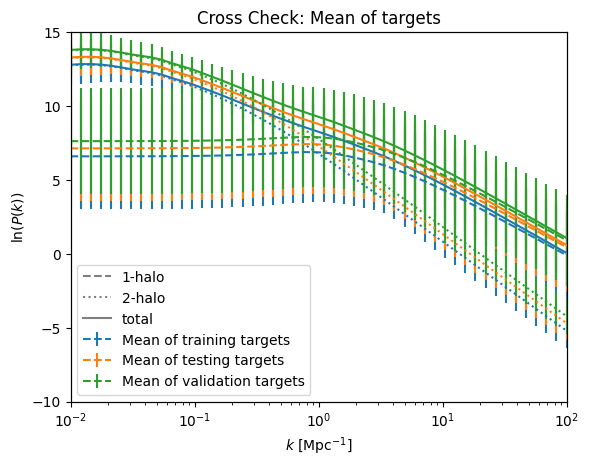

In [14]:
ks = np.geomspace(1e-2, 1e2)

fig, axes=plt.subplots()

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\ln(P(k))$')
plt.title('Cross Check: Mean of targets')


ax2=axes.twinx()
ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='grey')




ax2.legend(loc='lower left')


plt.xlim(1e-2,100)
plt.ylim(-10, 15)
axes.set_ylim(-10, 15)
ax2.set_yticks([])
axes.set_xscale('log')
axes.set_yscale('linear')


# Plot training targets
plt.errorbar(ks, mean_training_targets[0], ls='--',
             yerr=std_training_targets[0], color='C0', label='Mean of training targets', fmt='')
plt.errorbar(ks, mean_training_targets[1], ls=':', 
             yerr= std_training_targets[1], color='C0', fmt='')
plt.errorbar(ks, mean_training_targets[2], 
             yerr=std_training_targets[2], color='C0', fmt='')

# Plot testing targets
plt.errorbar(ks, mean_testing_targets[0]+0.5, ls='--',
             yerr=std_testing_targets[0], color='C1', label='Mean of testing targets', fmt='')
plt.errorbar(ks, mean_testing_targets[1]+0.5, ls=':', 
             yerr= std_testing_targets[1], color='C1', fmt='')
plt.errorbar(ks, mean_testing_targets[2]+0.5, 
             yerr=std_testing_targets[2], color='C1', fmt='')

# Plot validation targets
plt.errorbar(ks, mean_validation_targets[0]+1, ls='--',
             yerr=std_validation_targets[0], color='C2', label='Mean of validation targets', fmt='')
plt.errorbar(ks, mean_validation_targets[1]+1, ls=':', 
             yerr= std_validation_targets[1], color='C2', fmt='')
plt.errorbar(ks, mean_validation_targets[2]+1, 
             yerr=std_validation_targets[2], color='C2', fmt='')

plt.legend()
plt.savefig('../Plots/FinalExamples/CrossCheckTargets.png', dpi=600)
plt.show()

In [ ]:
mean_training_features = []
std_training_features = []

mean_testing_features = []
std_testing_features = []

mean_validation_features = []
std_validation_features = []

# Calculate mean and standard deviation for training features
for i in range(len(training_features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(training_features[:,i])
    
    mean = np.mean(feature_parameter, axis=0)  # mean over complete training sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete training sample for every k-value
    
    mean_training_features.append(mean)
    std_training_features.append(std)

# Calculate mean and standard deviation for testing features
for i in range(len(testing_features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(testing_features[:,i])

    mean = np.mean(feature_parameter, axis=0) # mean over complete testing sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete testing sample for every k-value

    mean_testing_features.append(mean)
    std_testing_features.append(std)

# Calculate mean and standard deviation for validation features
for i in range(len(validation_features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(validation_features[:,i])

    mean = np.mean(feature_parameter, axis=0)  # mean over complete validation sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete validation sample for every k-value

    mean_validation_features.append(mean)
    std_validation_features.append(std)




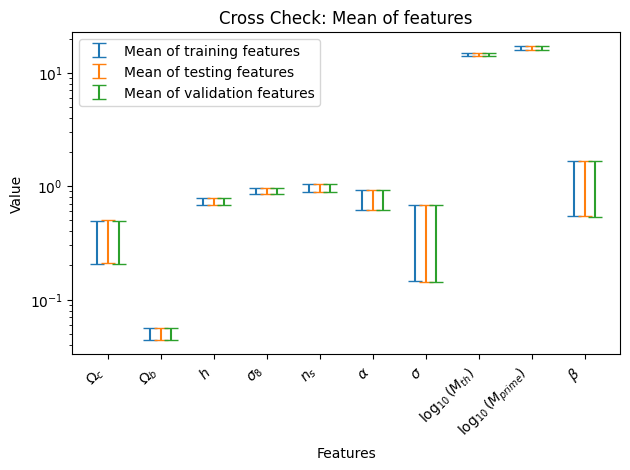

In [16]:
x_pos = np.arange(len(feature_keys))  # numerische Positionen für die x-Werte
offset = 0.2  # Abstand, um die Features ein bisschen zu verschieben

fig, axes = plt.subplots()

axes.set_xlabel('Features')
axes.set_ylabel('Value')
axes.set_title('Cross Check: Mean of features')

# Optional: Y-Achse logarithmisch
axes.set_xscale('linear')
axes.set_yscale('log')

# Training Features
axes.errorbar(x_pos - offset, mean_training_features, 
              yerr=std_training_features, ls='none', 
              color='C0', label='Mean of training features', capsize=5)

# Testing Features
axes.errorbar(x_pos, mean_testing_features, 
              yerr=std_testing_features, ls='none', 
              color='C1', label='Mean of testing features', capsize=5)

# Validation Features
axes.errorbar(x_pos + offset, mean_validation_features, 
              yerr=std_validation_features, ls='none', 
              color='C2', label='Mean of validation features', capsize=5)

# Setze die Original-Feature-Namen als x-Achsen-Beschriftung
axes.set_xticks(x_pos)
axes.set_xticklabels(['$\\Omega_c$', '$\\Omega_b$', '$h$', '$\\sigma_8$', '$n_s$', '$\\alpha$', '$\\sigma$', '$\log_{10}(M_{th})$', '$\log_{10}(M_{prime})$', '$\\beta$' ])
plt.xticks(rotation=45, ha='right')

# Legende
axes.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Justiere den unteren Rand des Plots
plt.savefig('../Plots/FinalExamples/CrossCheckFeatures.png', dpi=600)
plt.show()

feature_keys = ['Om_c', 'Om_b', 'h', 'sigma_8', 'n_s', 'alpha', 'sigma', 'Mth', 'Mprime', 'beta']

## Renaming

In [ ]:
# features
train_targets=training_targets['targets']
test_targets=testing_targets['targets']
val_targets=validation_targets['targets']

## Rescaling
We are rescaling the features by the mean and standard deviation of the training features. Then, they are all scattering by 1 and have a mean value of 0.


In [18]:
# Calculate mean and standard deviation **only from the training data**
target_processing_vectors = {
    'mean': np.mean(train_targets, axis=1, keepdims=True),
    'sigma': np.std(train_targets, axis=1, keepdims=True)
}

# Ensure that no division by zero occurs
target_processing_vectors['sigma'][target_processing_vectors['sigma'] == 0] = 1  

# Preprocessing function
def preprocessing(targets, processing_vectors):
    return (targets - processing_vectors['mean']) / processing_vectors['sigma']

# Postprocessing function
def postprocessing(targets, processing_vectors):
    return targets * processing_vectors['sigma'] + processing_vectors['mean']

# Apply preprocessing to all data
train_targets_rescaled = preprocessing(train_targets, target_processing_vectors)
test_targets_rescaled = preprocessing(test_targets, target_processing_vectors)
val_targets_rescaled = preprocessing(val_targets, target_processing_vectors)

# JSON-compatible storage of the processing vectors
#serializable_processing_vectors = {key: value.tolist() for key, value in processing_vectors.items()}
#processing_out="../Emulators/NM_processing_vectors.json"
#with open(processing_out, "w") as json_file:
#    json.dump(serializable_processing_vectors, json_file)

# Check shapes after the transformation
print("Train Rescaled Shape:", train_targets_rescaled.shape)
print("Test Rescaled Shape:", test_targets_rescaled.shape)
print("Val Rescaled Shape:", val_targets_rescaled.shape)



Train Rescaled Shape: (3, 50000, 50)
Test Rescaled Shape: (3, 307826, 50)
Val Rescaled Shape: (3, 10000, 50)


In [19]:
mean_training_targets_rescaled = []
std_training_targets_rescaled = []

mean_testing_targets_rescaled = []
std_testing_targets_rescaled = []

mean_validation_targets_rescaled = []
std_validation_targets_rescaled = []

# Calculate mean and standard deviation for rescaled training targets
for i in range(len(train_targets_rescaled)):  # for all 3-Halo terms
    halo_data_rescaled = np.array(train_targets_rescaled[i])

    mean = np.mean(halo_data_rescaled, axis=0)  # mean over complete rescaled training sample for every k-value
    std = np.std(halo_data_rescaled, axis=0)    # standard deviation over complete rescaled training sample for every k-value

    mean_training_targets_rescaled.append(mean)
    std_training_targets_rescaled.append(std)

# Calculate mean and standard deviation for rescaled testing targets
for i in range(len(test_targets_rescaled)):  # for all 3-Halo terms
    halo_data_rescaled = np.array(test_targets_rescaled[i])

    mean = np.mean(halo_data_rescaled, axis=0)  # mean over complete rescaled testing sample for every k-value
    std = np.std(halo_data_rescaled, axis=0)    # standard deviation over complete rescaled testing sample for every k-value

    mean_testing_targets_rescaled.append(mean)
    std_testing_targets_rescaled.append(std)

# Calculate mean and standard deviation for rescaled validation targets
for i in range(len(val_targets_rescaled)):  # for all 3-Halo terms
    halo_data_rescaled = np.array(val_targets_rescaled[i])

    mean = np.mean(halo_data_rescaled, axis=0)  # mean over complete rescaled validation sample for every k-value
    std = np.std(halo_data_rescaled, axis=0)    # standard deviation over complete rescaled validation sample for every k-value

    mean_validation_targets_rescaled.append(mean)
    std_validation_targets_rescaled.append(std)

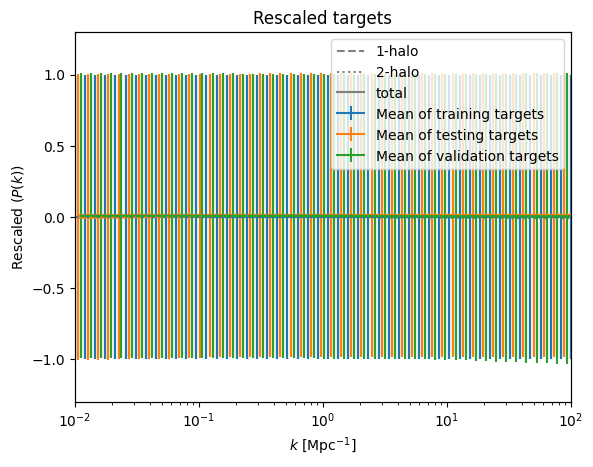

In [20]:
fig, axes=plt.subplots()
#axes.loglog(ks, Pk_lin, color='k', label='linear')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'Rescaled $(P(k))$')
plt.title('Rescaled targets')

ax2=axes.twinx()
ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='grey')
ax2.set_yticks([])



plt.errorbar(ks,mean_training_targets_rescaled[0], 
             yerr=std_training_targets_rescaled[0], color='C0', label='Mean of training targets')
plt.errorbar(ks,mean_training_targets_rescaled[1], ls=':', 
             yerr=std_training_targets_rescaled[1], color='C0')
plt.errorbar(ks,mean_training_targets_rescaled[2], ls='--', 
             yerr=std_training_targets_rescaled[2], color='C0')

plt.errorbar(ks*1.06,mean_testing_targets_rescaled[0], 
             yerr=std_testing_targets_rescaled[0], color='C1', label='Mean of testing targets')
plt.errorbar(ks*1.06,mean_testing_targets_rescaled[1], ls=':', 
             yerr=std_testing_targets_rescaled[1], color='C1')
plt.errorbar(ks*1.06,mean_testing_targets_rescaled[2], ls='--', 
             yerr=std_testing_targets_rescaled[2], color='C1')

plt.errorbar(ks*1.12,mean_validation_targets_rescaled[0], 
             yerr=std_validation_targets_rescaled[0], color='C2', label='Mean of validation targets')
plt.errorbar(ks*1.12,mean_validation_targets_rescaled[1], ls=':', 
             yerr=std_validation_targets_rescaled[1], color='C2')
plt.errorbar(ks*1.12,mean_validation_targets_rescaled[2], ls='--', 
             yerr=std_validation_targets_rescaled[2], color='C2')

axes.set_ylim(-1.3, 1.3)
plt.xlim(1e-2,100)
plt.ylim(-1.3,1.3)
plt.xscale('log')
plt.legend()
plt.savefig('../Plots/FinalExamples/RescaledTargets.png', dpi=600)

In [21]:
# Calculate mean and standard deviation **only from the training data**
feature_processing_vectors = {
    'mean': np.array(mean_training_features).reshape(1, -1),
    'sigma': np.array(std_training_features).reshape(1, -1)
}


# Ensure that no division by zero occurs
feature_processing_vectors['sigma'][feature_processing_vectors['sigma'] == 0] = 1  

# Preprocessing function
def preprocessing(features, processing_vectors):
    return (features - processing_vectors['mean']) / processing_vectors['sigma']

# Postprocessing function
def postprocessing(features, processing_vectors):
    return features * processing_vectors['sigma'] + processing_vectors['mean']

# Apply preprocessing to all data
train_features_rescaled = preprocessing(training_features, feature_processing_vectors)
test_features_rescaled = preprocessing(testing_features, feature_processing_vectors)
val_features_rescaled = preprocessing(validation_features, feature_processing_vectors)

# JSON-compatible storage of the processing vectors
#serializable_processing_vectors = {key: value.tolist() for key, value in processing_vectors.items()}
#processing_out="../Emulators/NM_processing_vectors.json"
#with open(processing_out, "w") as json_file:
#    json.dump(serializable_processing_vectors, json_file)

# Check shapes after the transformation
print("Train Rescaled Shape:", train_features_rescaled.shape)
print("Test Rescaled Shape:", test_features_rescaled.shape)
print("Val Rescaled Shape:", val_features_rescaled.shape)



Train Rescaled Shape: (50000, 10)
Test Rescaled Shape: (307826, 10)
Val Rescaled Shape: (10000, 10)


In [ ]:


mean_training_features_rescaled = []
std_training_features_rescaled = []

mean_testing_features_rescaled = []
std_testing_features_rescaled = []

mean_validation_features_rescaled = []
std_validation_features_rescaled = []


# Calculate mean and standard deviation for training features
for i in range(len(train_features_rescaled[0])):  # for all 3-Halo terms
    feature_parameter = np.array(train_features_rescaled[:,i])
    
    mean = np.mean(feature_parameter, axis=0)  # mean over complete training sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete training sample for every k-value
    mean_training_features_rescaled.append(mean)
    std_training_features_rescaled.append(std)

# Calculate mean and standard deviation for testing features
for i in range(len(test_features_rescaled[0])):  # for all 3-Halo terms
    feature_parameter = np.array(test_features_rescaled[:,i])

    mean = np.mean(feature_parameter, axis=0) # mean over complete testing sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete testing sample for every k-value

    mean_testing_features_rescaled.append(mean)
    std_testing_features_rescaled.append(std)

# Calculate mean and standard deviation for validation features
for i in range(len(val_features_rescaled[0])):  # for all 3-Halo terms
    feature_parameter = np.array(val_features_rescaled[:,i])

    mean = np.mean(feature_parameter, axis=0)  # mean over complete validation sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete validation sample for every k-value

    mean_validation_features_rescaled.append(mean)
    std_validation_features_rescaled.append(std)

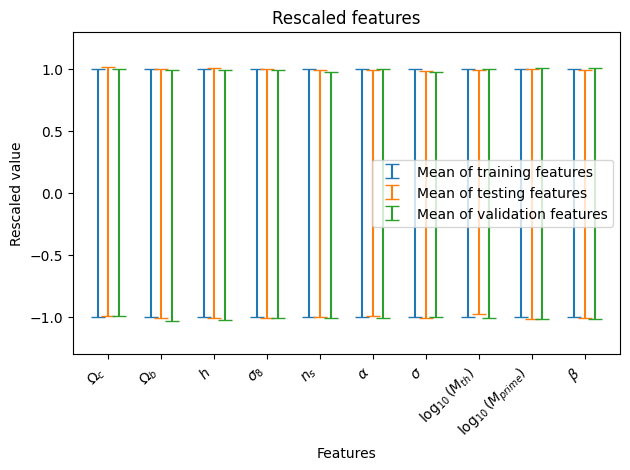

In [23]:
x_pos = np.arange(len(feature_keys))  # numerische Positionen für die x-Werte
offset = 0.2  # Abstand, um die Features ein bisschen zu verschieben

fig, axes = plt.subplots()

axes.set_xlabel('Features')
axes.set_ylabel('Rescaled value')
axes.set_title('Rescaled features')

# Optional: Y-Achse logarithmisch
axes.set_xscale('linear')
axes.set_yscale('linear')

# Training Features
axes.errorbar(x_pos - offset, mean_training_features_rescaled, 
              yerr=std_training_features_rescaled, ls='none', 
              color='C0', label='Mean of training features', capsize=5)

# Testing Features
axes.errorbar(x_pos, mean_testing_features_rescaled, 
              yerr=std_testing_features_rescaled, ls='none', 
              color='C1', label='Mean of testing features', capsize=5)

# Validation Features
axes.errorbar(x_pos + offset, mean_validation_features_rescaled, 
              yerr=std_validation_features_rescaled, ls='none', 
              color='C2', label='Mean of validation features', capsize=5)

# Setze die Original-Feature-Namen als x-Achsen-Beschriftung
axes.set_xticks(x_pos)
axes.set_xticklabels(['$\\Omega_c$', '$\\Omega_b$', '$h$', '$\\sigma_8$', '$n_s$', '$\\alpha$', '$\\sigma$', '$\log_{10}(M_{th})$', '$\log_{10}(M_{prime})$', '$\\beta$' ])
plt.xticks(rotation=45, ha='right')


axes.set_ylim(-1.3, 1.3)
plt.ylim(-1.3,1.3)
# Legende
plt.legend(loc='center right')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Justiere den unteren Rand des Plots
plt.savefig('../Plots/FinalExamples/RescaledFeatures.png', dpi=600)
plt.show()